<a href="https://colab.research.google.com/github/hansl404/introhlt/blob/hw1/intro_hlt_hw1_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1

In the first assignment, you will implement some of the algorithms you have learnt in the first two weeks of lectures: n-gram language models, and syntactic parsing using the CYK algorithm.

# Setup

For this and other assignments, we will be using Google Colab, for both code as well as descriptive questions. Your task is to finish all the questions in the Colab notebook and then upload a PDF version of the notebook, and a viewable link on Gradescope.

### Google colaboratory

Before getting started, get familiar with google colaboratory:
https://colab.research.google.com/notebooks/welcome.ipynb

This is a neat python environment that works in the cloud and does not require you to
set up anything on your personal machine
(it also has some built-in IDE features that make writing code easier).
Moreover, it allows you to copy any existing collaboratory file, alter it and share
with other people.

### Submission

Before you start working on this homework do the following steps:

1. Press __File > Save a copy in Drive...__ tab. This will allow you to have your own copy and change it.
2. Follow all the steps in this collaboratory file and write / change / uncomment code as necessary.
3. Do not forget to occasionally press __File > Save__ tab to save your progress.
4. After all the changes are done and progress is saved press __Share__ button (top right corner of the page), press __get shareable link__ and make sure you have the option __Anyone with the link can view__ selected. Copy the link and paste it in the box below.
5. After completing the notebook, press __File > Download .ipynb__ to download a local copy on your computer, and then upload the file to Gradescope.


__Paste your notebook link in the box below.__ _(0 points)_

```
# Paste your Colab notebook link here
```
https://colab.research.google.com/drive/1hY6O9HXXW2TYa2kJlsUhc303fT8f-C9H



In [1]:
# Downloads required packages and files
required_files = "https://github.com/jhu-intro-hlt/jhu-intro-hlt.github.io/raw/master/assignments/hw1-files/student/required_files.zip"
! wget $required_files && unzip -o required_files.zip
! pip install -r requirements.txt

--2025-09-07 13:55:38--  https://github.com/jhu-intro-hlt/jhu-intro-hlt.github.io/raw/master/assignments/hw1-files/student/required_files.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jhu-intro-hlt/jhu-intro-hlt.github.io/master/assignments/hw1-files/student/required_files.zip [following]
--2025-09-07 13:55:38--  https://raw.githubusercontent.com/jhu-intro-hlt/jhu-intro-hlt.github.io/master/assignments/hw1-files/student/required_files.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12284 (12K) [application/zip]
Saving to: ‘required_files.zip’

required_files.zip  100%[===============

In [2]:
# Initialize Otter
import otter
grader = otter.Notebook(colab=True)

In [3]:
import random
import math
import re
import os
import urllib
import json
from typing import *
from collections import Counter, defaultdict

import numpy as np
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer, sent_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Part 1: N-gram Language Models

For the first part of this assignment, you will implement a trigram language model and train it on a small corpus. You will then implement a scoring function to compute the perplexity of the model on a held-out test set. Finally, you will implement some methods to deal with sparsity (zero count) issues in your model.

To ease you into the implementation, we will provide some boilerplate code that you would need to fill in depending upon the functionalities the code is supposed to perform. For the first few sections below, we will use the complete text from Leo Tolstoy's "War and Peace," which is freely available from [Project Gutenberg](https://www.gutenberg.org/). Run the following code block to download the text.

In [4]:
def download_data():
    def _download(url: str, filename: str) -> str:
        txt = urllib.request.urlopen(url)
        with open(filename, 'w') as f:
            f.write(txt.read().decode('utf-8'))

    _download('https://cs.stanford.edu/people/karpathy/char-rnn/warpeace_input.txt', 'warpeace_input.txt')
    _download('http://www.gutenberg.org/files/1399/1399-0.txt', '1399-0.txt')

download_data()

The complete text downloaded above contains punctuations which are not important for our purposes. So we will perform a basic text preprocessing using the [NLTK toolkit](https://www.nltk.org/). We will store the processed text into a list of strings, where each string will contain words without any punctuations. We will also convert all words to lower case.

In [5]:
# Loading the text
try:
    with open('warpeace_input.txt', 'r') as file:
        corpus_raw = file.read().replace('\n', ' ')
except FileNotFoundError:
    with open('../../warpeace_input.txt', 'r') as file:
        corpus_raw = file.read().replace('\n', ' ')

In [253]:
sentences = sent_tokenize(corpus_raw)

corpus = []
tokenizer = RegexpTokenizer(r'\w+')
for sentence in sentences:
    tokens = tokenizer.tokenize(sentence)
    corpus.append([token.lower() for token in tokens])
# print(corpus)
print("Corpus has {} sentences".format(len(corpus)))

Corpus has 32040 sentences


### Warm-up: n-gram counts from a corpus

Let's start with implementing a simple function for obtaining n-grams and their counts from a string. Complete the following function. _(5 points)_

__Note 1:__ Use the special token `~` for both beginning of sentence (BOS) and end of sentence (EOS) tokens. For example, the sentence "Mary has a little lamb" has the bigrams "_~ Mary_", "_Mary has_", "_has a_", "_a little_", "_little lamb_", and "_lamb ~_".

__Note 2:__ You don't need to do any further text processing beyond what has already been done before.

__Note 3:__ For the usage of `collections.Counter`, you can refer to [its python doc](https://docs.python.org/3/library/collections.html#collections.Counter).

In [7]:
def generate_ngrams(text: List[str], n: int) -> Counter:
    """Generates all n-grams (i.e. n-1 context words) for the given text.

    Parameters
    ----------
    text : List[str]
        Input text (list of strings) after tokenization.
    n : int
        n-gram parameter (must be greater than or equal to 1).

    Returns
    -------
    ngrams : Counter
        Output n-grams dictionary as {ngram: count} (Dict[Tuple, int]),
        where `ngram` is a n-gram tuple and `count` is an integer count.
        e.g. ('Mary','has') and value as count of the n-gram in the text.
    """
    assert (isinstance(n, int) and n > 0)

    ngrams = Counter()

    # TODO: Your code here.
    eosbos = ["~"] * (n-1) + text + ["~"] * (n-1)
    for i in range(len(eosbos)-n+1):
      ngram = tuple(eosbos[i:i+n])
      ngrams[ngram] += 1

    return ngrams


def generate_ngrams_sentences(text: List[List[str]], n: int) -> Counter:
    """Generates n-grams for each sentence and aggregates them."""
    all_ngrams = Counter()
    for sentence in text:
        all_ngrams.update(generate_ngrams(sentence, n))
    return all_ngrams

In [255]:
# Test your implementation on some sentences from the corpus we downloaded above
# and verify if it works correctly.
text = corpus[:10]
# print(text)

ngrams = generate_ngrams_sentences(text, 3)
print(ngrams)

Counter({('~', '~', 'but'): 2, ('no', 'longer', 'my'): 2, ('~', '~', 'well'): 1, ('~', 'well', 'prince'): 1, ('well', 'prince', 'so'): 1, ('prince', 'so', 'genoa'): 1, ('so', 'genoa', 'and'): 1, ('genoa', 'and', 'lucca'): 1, ('and', 'lucca', 'are'): 1, ('lucca', 'are', 'now'): 1, ('are', 'now', 'just'): 1, ('now', 'just', 'family'): 1, ('just', 'family', 'estates'): 1, ('family', 'estates', 'of'): 1, ('estates', 'of', 'the'): 1, ('of', 'the', 'buonapartes'): 1, ('the', 'buonapartes', '~'): 1, ('buonapartes', '~', '~'): 1, ('~', 'but', 'i'): 1, ('but', 'i', 'warn'): 1, ('i', 'warn', 'you'): 1, ('warn', 'you', 'if'): 1, ('you', 'if', 'you'): 1, ('if', 'you', 'don'): 1, ('you', 'don', 't'): 1, ('don', 't', 'tell'): 1, ('t', 'tell', 'me'): 1, ('tell', 'me', 'that'): 1, ('me', 'that', 'this'): 1, ('that', 'this', 'means'): 1, ('this', 'means', 'war'): 1, ('means', 'war', 'if'): 1, ('war', 'if', 'you'): 1, ('if', 'you', 'still'): 1, ('you', 'still', 'try'): 1, ('still', 'try', 'to'): 1, ('tr

In [256]:
grader.check("warmup-ngram")

warmup-ngram results: All test cases passed!

<!-- BEGIN QUESTION -->

__Question:__ Plot a histogram of counts vs. number of unigrams with that count (you can choose a subset of the corpus, say 500 sentences). Repeat for bigrams and trigrams. They should be all placed into a single plot. _(3 points)_

['well', 'prince', 'so', 'genoa', 'and', 'lucca', 'are', 'now', 'just', 'family', 'estates', 'of', 'the', 'buonapartes', 'but', 'i', 'warn', 'you', 'if', 'you', 'don', 't', 'tell', 'me', 'that', 'this', 'means', 'war', 'if', 'you', 'still', 'try', 'to', 'defend', 'the', 'infamies', 'and', 'horrors', 'perpetrated', 'by', 'that', 'antichrist', 'i', 'really', 'believe', 'he', 'is', 'antichrist', 'i', 'will', 'have', 'nothing', 'more', 'to', 'do', 'with', 'you', 'and', 'you', 'are', 'no', 'longer', 'my', 'friend', 'no', 'longer', 'my', 'faithful', 'slave', 'as', 'you', 'call', 'yourself', 'but', 'how', 'do', 'you', 'do', 'i', 'see', 'i', 'have', 'frightened', 'you', 'sit', 'down', 'and', 'tell', 'me', 'all', 'the', 'news', 'it', 'was', 'in', 'july', '1805', 'and', 'the', 'speaker', 'was', 'the', 'well', 'known', 'anna', 'pavlovna', 'scherer', 'maid', 'of', 'honor', 'and', 'favorite', 'of', 'the', 'empress', 'marya', 'fedorovna', 'with', 'these', 'words', 'she', 'greeted', 'prince', 'vasili

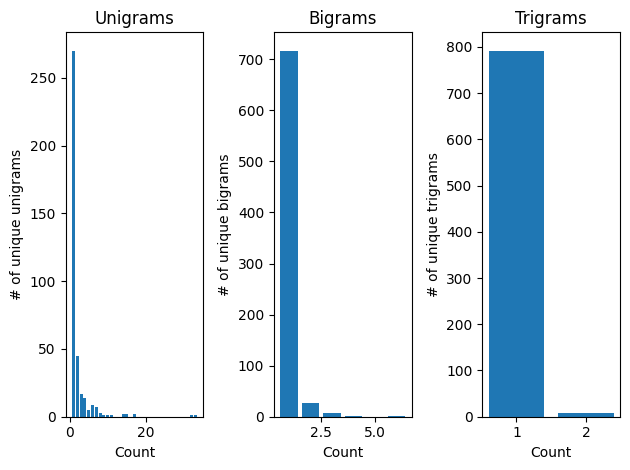

In [257]:
fig, axs = plt.subplots(1, 3, tight_layout=True)

# Picks a subset of the corpus
# TODO: Your code here
sample = corpus[:50]
flatten = [token for sentence in sample for token in sentence]
print(flatten)

# Unigram counts
# TODO: Your code here
unigrams = generate_ngrams(flatten, 1)
unigram_counts = Counter(unigrams.values())
axs[0].bar(unigram_counts.keys(), unigram_counts.values())
axs[0].set_title("Unigrams")
axs[0].set_xlabel("Count")
axs[0].set_ylabel("# of unique unigrams")

# Bigram counts
# TODO: Your code here
bigrams = generate_ngrams(flatten, 2)
bigram_counts = Counter(bigrams.values())
axs[1].bar(bigram_counts.keys(), bigram_counts.values())
axs[1].set_title("Bigrams")
axs[1].set_xlabel("Count")
axs[1].set_ylabel("# of unique bigrams")

# Trigram counts
# TODO: Your code here
trigrams = generate_ngrams(flatten, 3)
trigram_counts = Counter(trigrams.values())
axs[2].bar(trigram_counts.keys(), trigram_counts.values())
axs[2].set_title("Trigrams")
axs[2].set_xlabel("Count")
axs[2].set_ylabel("# of unique trigrams")


plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

__Question:__ What observation can you make from the plots? _(2 points)_

__Answer:__

There are many unigrams that appear multiple times, but very few trigrams that appear several times. The higher the n-value of the n-gram, the more unique values there are.

<!-- END QUESTION -->

### Implementing an n-gram language model

Next, you will implement a class for an trigram (n=3) language model. This will be a barebones trigram LM, i.e., no smoothing or OOV handling is required. Complete
the functions in the following `NgramLM` class. _(20 points)_

Note that the class itself is
for a general n-gram LM, but we will instantiate it with n=3.

_Type your answer here, replacing this text._

In [258]:
class NgramLM(object):
    """A basic n-gram language model without any smoothing."""

    def __init__(self, n: int):
        assert (isinstance(n, int) and n > 0)

        self.n: int = n
        self.vocab: Set[str] = set()  # A set of all words appearing in the corpus.
        self.ngrams = Counter()  # count(ABC) - Dict[Tuple, int]
        self.ngram_contexts = Counter()  # count(AB) - Dict[Tuple, int]
        self.contexts = defaultdict(set)  # {AB: {C1,C2,C2}} - Dict[Tuple, Set[str]]

    def generate_ngrams(self, text: List[str]) -> Counter:
        """Generates all n-grams (i.e. n-1 context words) for the given text.
        In this method, we assume n is defined at the class initialization,
        so you should use `self.n`.

        Parameters
        ----------
        text : List[str]
            Input text (list of strings) after tokenization.

        Returns
        -------
        ngrams : Counter
            Output n-grams dictionary as {ngram: count} (Dict[Tuple, int]),
            where `ngram` is a n-gram tuple and `count` is an integer count.
            e.g. ('Mary','has') and value as count of the n-gram in the text.
        """
        return generate_ngrams(text, self.n)

    def generate_ngrams_sentences(self, text: List[List[str]]) -> Counter:
        """Generates n-grams for each sentence and aggregates them."""
        return generate_ngrams_sentences(text, self.n)

    def update(self, text: List[str]):
        """Updates the model n-grams based on the given text input.

        Parameters
        ----------
        text : List[str]
        """
        # TODO: Your code here
        self.vocab.update(text)

        # Ensure BOS/EOS symbol is in vocab
        self.vocab.add("~")

        # Generate n-grams (already pads with ~ in your generate_ngrams)
        new_ngrams = self.generate_ngrams(text)

        # Update n-gram counts
        self.ngrams.update(new_ngrams)

        for ngram, count in new_ngrams.items():
            context = ngram[:-1]
            word = ngram[-1]

            # Increment the count for the context (n-1 gram)
            self.ngram_contexts[context] += count

            # Add the word to the set of words that can follow the context
            self.contexts[context].add(word)

    def word_prob(self, context: Tuple[str], word: str) -> float:
        """Returns the probability of a word given a context. The context is a
        string of words, with length n-1.

        Parameters
        ----------
        context : Tuple[str]
            A tuple of words describing the context for the next word.
        word : str
            The next word that the probability is computed for.

        Returns
        -------
        prob : float
            The estimated probability of the next word given the context.
        """
        # TODO: Your code here
        expected_length = self.n-1
        context_count = self.ngram_contexts[context]
        if context_count == 0: return 0

        ngram = context + (word,)
        ngram_count = self.ngrams[ngram]

        return ngram_count/context_count


    def next_word_candidates(self, context: Tuple[str]) -> List[str]:
        """Generates a list of tokens based on the given context, which would be
        later used as candidates for the next word prediction.

        Parameters
        ----------
        context : Tuple[str]
            A tuple of words describing the context for the next word.

        Returns
        -------
        words : List[str]
            A list of candidate tokens for the next word.
        """
        # TODO: Your code here
        candidates = self.contexts[context]
        return list(candidates)

    def random_word(self, context: Tuple[str]) -> str:
        """Generates a random word based on the given context.

        Note:
        Please use a random function from `random` instead of `numpy`;
        otherwise, the autograder might not be happy.

        Parameters
        ----------
        context : Tuple[str]
            A tuple of words describing the context for the next word.

        Returns
        -------
        word : str
            One randomly drawn word from the distribution defined given the context.
        """
        assert context in self.contexts, f'Encountered unseen context={context}.'

        # TODO: Your code here
        candidates = self.next_word_candidates(context)
        weights = [self.ngrams[context+(word,)] for word in candidates]
        return random.choices(population=candidates, weights=weights, k=1)[0]

    def random_text(self, length: int) -> List[str]:
        """Generates random text of the specified word length excluding "~" (BOS).

        Note:
        - The final word of the generated text *can* be "~" (EOS), but it is not necessary.
        - The generation should always start with "~" (BOS).
        - Only the number of starting "~" (BOS) is excluded from the generation, any
        ending "~" (EOS) is still counted to the `length`. It means that you should
        draw a number of `length` samples.

        Note:
        Please use a random function from `random` instead of `numpy`;
        otherwise, the autograder might not be happy.

        Parameters
        ----------
        length : int
            The designated length to generate.

        """
        # TODO: Your code here
        context = ("~",) * (self.n-1)  # start each sentence with ~
        generated_words = []
        for i in range(length):
          if context not in self.contexts: break
          next_word = self.random_word(context)
          generated_words.append(next_word)
          context = (context + (next_word,))[1:]

        return generated_words


In [259]:
# Training block for a trigram language model
import time
start = time.time()

trigramlm = NgramLM(3)
for sentence in corpus:
    trigramlm.update(sentence)

print(time.time() - start)

2.3404126167297363


In [13]:
grader.check("ngramlm-impl")

ngramlm-impl results: All test cases passed!

__Question:__ What is the size of the training data (number of tokens)? _(1 point)_

In [14]:
training_corpus_size = trigramlm.ngrams.total()
training_corpus_size

635904

__Question:__ What is the size of the vocabulary? _(1 point)_

In [15]:
trigramlm_vocab_size = len(trigramlm.vocab)
trigramlm_vocab_size

17511

<!-- BEGIN QUESTION -->

__Question:__ What is the optimal time complexity of computing ngrams? How long does the training take? _(2 points)_

*Note*: please use big-O notation to show the time complexity and explain variables involved accordingly.

__Answer:__

It is O(N) time complexity

In [260]:
# TODO: put the training time (in ms) of a trigram LM below.
trigram_training_time = 2340
trigram_training_time

2340

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

__Question:__ How would the training time scale if you have a corpus containing 1 billion tokens? Is this training time reasonable? If not, can you think of ways to improve it? _(2 points)_

__Answer:__

It would scale linearly, because we are creating a window of words around each word to generate the context. Therefore, the training time would still be reasonable

<!-- END QUESTION -->

#### Predicting/generating text using the trained LM

One of the applications of an LM is to automatically predict the next word given a context (such as in Smart Keyboards), or to generate a piece of text of a given length. Use the `random_word` and `random_text` functions you implemented earlier to answer the questions below. For full credit, you need to show how you arrived at the answer.

__Question:__ Please implement the function that computes an empirical distribution for the next word prediction conditioning on a context. Consider the context "by her". You can generate a random word for a large number of times, say 1000, using this context and count how many times each word are generated to calculate its empirical probability accordingly. _(3 points)_

In [261]:
def compute_empirical_distribution(model: NgramLM, context: Tuple[str], num_samples: int) -> Dict[str, float]:
    """Computes an empirical distribution for the next word conditioning on the given context.

    Parameters
    ----------
    model : NgramLM
        A trained Ngram Language Model.
    context : Tuple[str]
        The context used to predict a next word.
    num_samples : int
        The number of samples to be drawn to compute the empirical distribution.

    Returns
    -------
    emp_distr : Dict[str, float]
        An empirical distribution for the next word

    """
    emp_distr: Dict[str, float] = {}

    # TODO: Your code here
    for i in range(num_samples):
      simulated_word = model.random_word(context)  # get one random word
      emp_distr[simulated_word] = emp_distr.get(simulated_word,0) + (1/num_samples)  # add 1/num_samples to the probability, since we know we are running exactly num_samples times

    # print(model.word_prob(('by', 'her'), 'husband'))
    return emp_distr

In [262]:
compute_empirical_distribution(trigramlm, ('by', 'her'), 1000)

{'massive': 0.028000000000000018,
 'breadth': 0.028000000000000018,
 'side': 0.022000000000000013,
 'daughters': 0.024000000000000014,
 'thoughts': 0.022000000000000013,
 'garments': 0.015000000000000006,
 'father': 0.06600000000000004,
 '~': 0.08100000000000006,
 'husband': 0.08000000000000006,
 'sister': 0.057000000000000044,
 'daughter': 0.02000000000000001,
 'mother': 0.08800000000000006,
 'manners': 0.03000000000000002,
 'presence': 0.022000000000000013,
 'own': 0.027000000000000017,
 'self': 0.026000000000000016,
 'brother': 0.02000000000000001,
 'bare': 0.025000000000000015,
 'serious': 0.02100000000000001,
 'look': 0.022000000000000013,
 'and': 0.023000000000000013,
 'image': 0.016000000000000007,
 'body': 0.025000000000000015,
 'smiles': 0.015000000000000006,
 'friend': 0.022000000000000013,
 'beauty': 0.026000000000000016,
 'that': 0.028000000000000018,
 'attitude': 0.016000000000000007,
 'fullness': 0.028000000000000018,
 'spiritual': 0.024000000000000014,
 'feelings': 0.015

In [263]:
grader.check("ngramlm-empirical-distribution")

ngramlm-empirical-distribution results: All test cases passed!

<!-- BEGIN QUESTION -->

__Question:__ Does the empirical probability match the output of `word_prob(("by", "her"), "husband")`? Could you explain why it matches or not? Could you propose a way to measure how the empirical distribution differs from the theoretical distribution? _(3 points)_

__Answer:__

It does not exactly match, because empirical distribution involves random sampling, so the observed probability will differ due to randomness.

We could possibly measure how much empirical and theoretical distributions differ by squaring the differences in probabilities to account for differences in + and -, then average it out by dividing the squared result by theoretical probability so larger datasets don't always lead to larger differences.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

__Question:__ Generate a random text of length 100 words. Comment on the local and global semantics of the generated text. _(2 points)_

__Answer:__

_Type your answer here, replacing this text._

In [20]:
# TODO: Your code here
text = trigramlm.random_text(100)
generated_text = ' '.join(text)
print(generated_text)  # Please make sure this prints out a `str` instead of a `list`.

said pierre ~ ~ the major domo to whom he cared about was gaiety and spirit of an unpleasant and even the russian army and the heat of the main wheel of the first condition omitted that of the naked eye could distinguish a living being by the riverbanks and in good spirits on this advice ~ ~ he shouted to lavrushka who went up to a prominent position the heroes of that period have passed on with a song a door grown rusty on its wing ~ ~ never never marry anyone but you are such fine fellows ~


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

__Question:__ Now train a 4-gram LM on the same data and generate a 100-word text again. Do you observe any differences between the outputs of the two models? _(2 points)_

__Answer:__

The sentences make more grammatical sense

In [21]:
# You should train you 4-gram model here in the same way as training a trigram model
# You should use the same `corpus` for training
qgramlm = NgramLM(4)
qgramlm

In [22]:
# TODO: Your code here
for sentence in corpus:
    qgramlm.update(sentence)

ggram_list_text = qgramlm.random_text(100)
qgram_generated_text = ' '.join(ggram_list_text)
print(qgram_generated_text)  # Please make sure this prints out a `str` instead of a `list`.

she looked at him with a gesture of desperation slammed the door behind him and brightly lit up by the fire beside the officer with the long hair sighed deeply without removing his hand from his bosom and solemnly pointing to the plan of a market gardener who when driving out of his knapsack a scrap of blue french cloth and wrapped it round his foot ~ ~ ~ beams and wooden screens had been put in position ~ ~ ~ and this was true ~ ~ ~ i have had so little meaning for him that he might and


<!-- END QUESTION -->

### Evaluating the LM: Perplexity

In the context of language modeling, perplexity measures how an LM predicts a sample. It is computed as the per word inverse probability of a held-out set:

$$ Perplexity(W) = P(W_1 W_2 \ldots W_N)^{-1/N} $$

Complete the following function which computes the perplexity of an ngram language model given the class object and a dataset (represented as a list of strings as done earlier). _(8 points)_

__Note 1:__ You may assume that the text is normalized as done before, so no text processing is required in the function.

__Note 2:__ Consider performing computations in the log domain to avoid underflow errors. Recall the log equalities:

$$ P = 2^{\log_2 P} $$
$$ \log (a_1 a_2 \ldots a_N)^{1/N} = \frac{1}{N}\left( \log a_1 + \log a_2 + \ldots + \log a_N \right) $$

In [23]:
def perplexity(model: NgramLM, data: List[List[str]]) -> float:
    """Function to compute perplexity of ngram LM.

    Parameters
    ----------
    model : NgramLM
        A class object denoted a trained `NgramLM`.
    text : List[List[str]]
        A list of sentences, where each sentence is a list of tokens.

    Returns
    -------
    perp : float
        Perplexity of the LM on given string.
    """
    # TODO: Your code here
    total_log_prob = 0.0   # log a1 + log a2 + ...
    total_ngram_count = 0  # N

    for sentence in data:
        ngrams = model.generate_ngrams(sentence)  # ngrams is Counter({ ('~','~','with'): 1, ...})
        total_ngram_count += sum(ngrams.values())  # total number ngrams (sum the values)

        for ngram,count in ngrams.items():
            context = ngram[:-1]
            word = ngram[-1]
            prob = model.word_prob(context, word)  # prob of getting this one word given context

            if prob == 0:
                return float('inf')

            total_log_prob += count * math.log2(prob)   # log a1 + log a2 + ...

    cross_entropy = -total_log_prob / total_ngram_count  # ensure cross entropy is positive
    perp = 2 ** cross_entropy

    return perp

In [24]:
grader.check("ngramlm-perp-impl")

ngramlm-perp-impl results: All test cases passed!

__Question:__ What is the perplexity of the model on the training corpus? _(1 point)_

In [25]:
# TODO: Your code here
trigram_perp_on_training = perplexity(trigramlm, corpus)
trigram_perp_on_training

7.118221877916299

In [26]:
grader.check("ngramlm-tri-perp-on-training")

ngramlm-tri-perp-on-training results: All test cases passed!

__Question:__ What is the perplexity of the 4-gram LM you trained earlier on the training corpus? _(1 point)_

In [27]:
# TODO: Your code here
qgram_perp_on_training = perplexity(qgramlm, corpus)
qgram_perp_on_training

2.282866387179662

In [28]:
grader.check("ngramlm-quad-perp-on-training")

ngramlm-quad-perp-on-training results: All test cases passed!

You will now use your above implementation to evaluate your model on a small held out development set from Leo Tolstoy's Anna Karenina. First we download and preprocess this data similar to how we did for the training set.

In [29]:
# Process the text file to get the contents of Chapter 1
try:
    with open('1399-0.txt', 'r') as file:
        dev_raw = file.read().replace('\n', ' ')
except FileNotFoundError:
    with open('../../1399-0.txt', 'r') as file:
        dev_raw = file.read().replace('\n', ' ')

In [30]:
pattern = "Chapter 1(.*)Chapter 2"
dev_ch1 = re.search(pattern, dev_raw).group(1)

sentences = sent_tokenize(dev_ch1)

dev_text = []
tokenizer = RegexpTokenizer(r'\w+')
for sentence in sentences:
    tokens = tokenizer.tokenize(sentence)
    dev_text.append([token.lower() for token in tokens])

print("Dev data has {} sentences".format(len(dev_text)))

Dev data has 15883 sentences


__Question:__ Compute the perplexity of the 3-gram LM on the development set prepared above. _(1 points)_

In [31]:
# TODO: Your code here
trigram_perp_on_dev = perplexity(trigramlm, dev_text)
trigram_perp_on_dev

inf

In [32]:
grader.check("ngramlm-tri-perp-on-dev")

ngramlm-tri-perp-on-dev results: All test cases passed!

<!-- BEGIN QUESTION -->

__Question:__ What is the reason for this perplexity value? _(2 points)_

__Answer:__

An infinite perplexity value means that the model encountered a text it believed was impossible.

In the code, it was set so that `if prob == 0: return float('inf')`, meaning the model calculated that the probability of getting a certain word given a context was 0. This could happen if it encounters a word not in the vocabulary or a word was never preceded by the context it encountered in the test set

<!-- END QUESTION -->

### Zeros and generalization

From the above, you would have realized that our trigram LM in the barebones setting is probably not robust enough to be deployed in general settings, due to the data sparsity problem. This problem is dealt with by using "smoothing" methods for unseen n-grams and the `<UNK>` token for OOV words.

In this section, you will implement Laplace (add-one) smoothing and use the `<UNK>` token for handling OOV words in the evaluation set. Complete the following class definition to achieve this. _(15 points)_

In [270]:
class NgramLMWithLaplaceSmoothing(NgramLM):
    """An n-gram language model with OOV handling and Laplace smoothing.
    This class inherits all bahaviors from previous defined `NgramLM`.
    Please be careful with the implementations here as you have to be consistent
    with all interfaces.
    """
    # OOV = "out of vocabulary"
    def __init__(self, n: int):
        super(NgramLMWithLaplaceSmoothing, self).__init__(n=n)

    def next_word_candidates(self, context: Tuple[str]) -> List[str]:
        """Generates a list of tokens based on the given context, which would be
        later used as candidates for the next word prediction.

        Note: in this overriden version, you should deal with the OOV words.

        Parameters
        ----------
        context : Tuple[str]
            A tuple of words describing the context for the next word.

        Returns
        -------
        words : List[str]
            A list of candidate tokens for the next word.
        """
        # TODO: Your code here
        self.vocab.add("<UNK>")
        norm_context = tuple(w if w in self.vocab else "<UNK>" for w in context)
        if norm_context in self.contexts:
          candidates = self.contexts[norm_context]
        else:
          candidates = self.vocab

        candidates.add("<UNK>")
        return list(candidates)

    def word_prob(self, context: Tuple[str], word: str) -> float:
        """Returns the probability of a word given a context. The context is a
        string of words, with length n-1.

        Note: in this overriden version, you should deal with the OOV words.

        Parameters
        ----------
        context : Tuple[str]
            A tuple of words describing the context for the next word.
        word : str
            The next word that the probability is computed for.

        Returns
        -------
        prob : float
            The estimated probability of the next word given the context.
        """
        # TODO: Your code here
        context_count = self.ngram_contexts.get(context,0)  # add 0 if this context was not found
        ngram_count = self.ngrams.get(context + (word,), 0)  # get the number of times this n-gram was observed, else 0
        prob = (ngram_count + 1) / (context_count + len(self.vocab))  # add 1 to n-gram count and divide by new length of vocab
        return prob

In [271]:
# Training block for a trigram language model with Laplace smoothing
trigramlm_laplace = NgramLMWithLaplaceSmoothing(3)
for sentence in corpus:
    trigramlm_laplace.update(sentence)

__Question:__ Report the perplexity of the new LM on the development data. (3 points)

In [272]:
# TODO: Your code here
trigram_laplace_perp_on_training = perplexity(trigramlm_laplace, corpus)
trigram_laplace_perp_on_training

3992.195917410336

<!-- BEGIN QUESTION -->

__Question:__ Can you think of a different way to solve the OOV problem? _(2 points)_

__Answer:__

Instead of adding 1 observed count to unseen words in vocab, add a fractional count k

<!-- END QUESTION -->

__Question (extra credit):__ Laplace smoothing is a relatively naive smoothing method. In the lectures, you learnt about more advanced methods: Good-Turing, Backoff, Interpolation, Kneser-Ney. Implement any one of these smoothing methods (pick your favorite). Evaluate the resulting trigram LM on the development data and report the perplexity. Could you get some improvements (an improvement from the baseline would secure you to get an extra credit of 10 points)? _(10 points)_

__Leaderboard:__ It would be interesting to explore different techniques or combinations of techniques to improve trigram language models. For this extra credit question, we also introduce a leaderboard for people to compete their designs of language models. To encourage participantion, the top 15% and 30% would be given another 10 points and 5 points extra credit respectively. Have fun :-)

In [ ]:
class ImprovedNgramLM(NgramLM):
    """An improved version of n-gram language model with OOV handling.
    This class inherits all bahaviors from previous defined `NgramLM`.
    Please be careful with the implementations here as you have to be consistent
    with all interfaces.

    Note: you could override more methods provided by the base class, but you have
    to maintain their ability of handling the same types of inputs and outputs.
    """

    def __init__(self, n: int):
        super(ImprovedNgramLM, self).__init__(n=n)

        # TODO: Your code here, if you would like to change the behavior of init.

    def next_word_candidates(self, context: Tuple[str]) -> List[str]:
        """Generates a list of tokens based on the given context, which would be
        later used as candidates for the next word prediction.

        Note: in this overriden version, you should deal with the OOV words.

        Parameters
        ----------
        context : Tuple[str]
            A tuple of words describing the context for the next word.

        Returns
        -------
        words : List[str]
            A list of candidate tokens for the next word.
        """
        # TODO: Your code here
        ...

    def word_prob(self, context: Tuple[str], word: str) -> float:
        """Returns the probability of a word given a context. The context is a
        string of words, with length n-1.

        Note: in this overriden version, you should deal with the OOV words.

        Parameters
        ----------
        context : Tuple[str]
            A tuple of words describing the context for the next word.
        word : str
            The next word that the probability is computed for.

        Returns
        -------
        prob : float
            The estimated probability of the next word given the context.
        """
        # TODO: Your code here
        ...

In [ ]:
# Training block for a trigram language model
improved_trigramlm = ImprovedNgramLM(3)
for sentence in corpus:
    improved_trigramlm.update(sentence)

In [ ]:
grader.check("ngramlm-improvement-impl")

## Part 2: Parsing and the CYK algorithm

In the lecture on Syntax, you learnt about parsing algorithms, including the bottom-up CYK algorithm. In this section, you will implement the CYK algorithm for computing the parse tree of a sentence given a grammar.

You may look at the pseudocode on [Wikipedia](https://en.wikipedia.org/wiki/CYK_algorithm#As_pseudocode) or refer to descriptions of the CYK algorithm online (such as [this](https://courses.engr.illinois.edu/cs373/sp2009/lectures/lect_15.pdf)), but you may not copy code directly from another source. The objective of this exercise is to familiarize yourself with parsing.

First, we will provide some starter code to load a simple grammar which can be used to test your implementation. The CYK algorithm only works with context-free grammars (CFGs) in the [Chomsky Normal Form (CNF)](https://en.wikipedia.org/wiki/Chomsky_normal_form), but any CFG can be represented as an equivalent CNF. You can use NLTK to check if the grammar is in CNF.

In [36]:
# grammar rules

cfg_rules = """
S -> NP VP
PP -> P NP
NP -> Det N
NP -> Det N PP
NP -> 'I'
VP -> V NP
VP -> VP PP
Det -> 'an'
Det -> 'my'
N -> 'elephant'
N -> 'pajamas'
V -> 'shot'
P -> 'in'
"""

__Question:__ Use NLTK to check if the grammar `cfg` is in the Chomsky Normal Form. _(1 point)_

In [44]:
# TODO: Your code here
# Note:
# `is_cfg_cnf` should be the function name without executing it (by removing `()`).
# Executing this cell should give you a boolean result indicating whether the given CFG
# is in the Chomsky Normal Form.
is_cfg_cnf = nltk.grammar.CFG.fromstring(cfg_rules).is_chomsky_normal_form
is_cfg_cnf()

False

__Question:__ Convert the above CFG into CNF (use pen and paper) and create a new grammar using it. Use NLTK to verify if it is in CNF. _(4 points)_

Here are the steps to convert any CFG into a CNF:

1. Eliminate start symbol from the RHS. If the start symbol S is at the right-hand side of any production, create a new production as: S1 -> S
2. If CFG contains null, unit or useless production rules, eliminate them.
3. Eliminate terminals from RHS if they exist with other terminals or non-terminals.
4. Eliminate RHS with more than two non-terminals.

(Hint: There is only one offending rule in the above grammar.)

In [65]:
# Write the CNF grammar here as a string

# TODO: Your code here
cnf_cfg_rules = """
S -> NP VP
PP -> P NP
NP -> Det N
NP -> 'I'
VP -> V NP
VP -> VP PP
Det -> 'an'
Det -> 'my'
N -> 'elephant'
N -> 'pajamas'
V -> 'shot'
P -> 'in'
"""
# cnf_cfg_rules

test = nltk.grammar.CFG.fromstring(cnf_cfg_rules).is_chomsky_normal_form
test()

True

You can now use the above grammar and the sentence: _"I shot an elephant in my pajamas"_ to demonstrate your implementation of the CYK parser.

Complete the following code block to implement the parser. We have provided the definition of the Node class which stores a non-terminal, and some boilerplate code to ease you into the implementation. Your main task is to implement the `parse()` function, which generates the parse table in a bottom-up manner. The `parse_table` in the `CYKParser` class below can be thought of as a table which contains number of rows equal to the number of words in the sentence. _(25 points)_

_Note_:

We recommend reading the usage of [NLTK grammar object](https://www.nltk.org/howto/grammar.html) as we would parse the grammar to this object. It allows us to easily play with different grammar production rules. Sample usages (`grammar` is a `nltk.grammar.CFG` object instantiated from a given grammar):
  - `grammar.productions()`: list all production rules defined in the grammar.
  - `rule_i = grammar.productions()[i]`: get the ith rule from the grammar.
  - `rule_i.lhs()`: get the LHS for the given rule.
  - `rule_i.rhs()`: get the RHS for the given rule.
  - `rule_i.is_lexical()`: determine whether it is a terminal rule.
  - `rule_i.is_nonlexical()`: determine whether it is a non-terminal rule.
  - `rhs_0 = rule_i.rhs()[0]`: get the first element on the RHS for the given rule.
  - `rhs_0.symbol()`: get the `str` symbol of the RHS element (this also applies to the LHS element).
  
_Hint: It may be beneficial to first run through the algorithm for the given grammar and the sentence on pen and paper._

In [249]:
class Node:
    """ Equivalent to a non-terminal. Since our grammar is CNF, a node can have at
    most 2 children. Following 2 cases are possible:

    Case 1 -> child1 is a terminal symbol
    Case 2 -> both child1 and child2 are Nodes.
    """

    def __init__(self, symbol, child1, child2=None):
        self.symbol = symbol
        self.child1 = child1
        self.child2 = child2

    def __repr__(self):
        """Returns the string representation of a Node object."""
        return self.symbol

    def generate_tree(self) -> str:
        """Generates the string representation of the tree rooted at the current node.
        It is done via pre-order tree traversal.

        Returns
        -------
        str_tree : str
            The tree in its string form.
        """
        if self.child2 is None:
            return f"[{self.symbol} '{self.child1}']"
        return f"[{self.symbol} {self.child1.generate_tree()} {self.child2.generate_tree()}]"


class CYKParser(object):
    """A CYK parser which is able to parse any grammar in CNF. The parser object
    is created from a CNF grammar and can be used to parse any sentence.
    """

    def __init__(self, grammar: str):
        """Creates a new parser object.

        Parameters
        ----------
        grammar : str
            Input grammar as a string of rules.
        """
        self.grammar: nltk.grammar.CFG = nltk.grammar.CFG.fromstring(grammar)

    def print_tree(self, parse_table: List[List[List[Node]]]):
        """Prints the parse tree starting with the start symbol.
        """
        start_symbol = self.grammar.start().symbol()
        final_nodes = [n for n in parse_table[-1][0] if n.symbol == start_symbol]
        if final_nodes:
            print("\nPossible parse(s):")
            trees = [node.generate_tree() for node in final_nodes]
            for tree in trees:
                print(tree)
        else:
            print("The given sentence is not contained in the language produced by the given grammar!")

    def parse(self, sentence: List[str]) -> List[List[List[Node]]]:
        """Does the actual parsing according to the CYK algorithm.

        Parameters
        ----------
        sentence : List[str]
            An input sentence in the form of list of tokens.

        Returns
        -------
        parse_table : List[List[List[Node]]]
            The resulting parse table for the sentence under the grammar.
        """
        num_tokens = len(sentence)
        # parse_table[y][x] is the list of nodes in the x+1 cell
        # of y+1 row in the table. That cell covers the word below it
        # and y more words after.
        parse_table: List[List[List[Node]]] = [[[] for x in range(num_tokens - y)] for y in range(num_tokens)]

         # TODO: Your code here
        grammar = nltk.grammar.CFG.fromstring(cnf_cfg_rules)

        # initialize the parse table
        for i in range(len(sentence)):  # loop through sentence
          for rule in grammar.productions():
            if rule.is_lexical() and rule.rhs()[0] == sentence[i]:
              parse_table[i][0].append(rule.lhs())

        # dynamic programming to build up
        for length in range(1,num_tokens):  # from Wikipedia: length = 2->n
          # print(sentence[length:])
          for start in range(num_tokens-length):  # from Wikipedia: s = 1 to n-l+1
            # print(sentence[length:][start:])
            for partition in range(1,length+1):   # from Wikipedia: p = 1 to l-1, this is like (1)23, (12)3, ...
              left_cell = parse_table[start][partition-1]
              right_cell = parse_table[start+partition][length-partition]
              for rule in grammar.productions():
                if not rule.is_lexical() and len(rule.rhs()) == 2:  # 2 nonterminals
                  B,C = rule.rhs()
                  if B in left_cell and C in right_cell:
                    parse_table[start][length].append(rule.lhs())

        return parse_table

In [250]:
parser = CYKParser(cnf_cfg_rules)
parse_table = parser.parse("I shot an elephant in my pajamas".split())

In [251]:
parser.print_tree(parse_table)

The given sentence is not contained in the language produced by the given grammar!


In [252]:
grader.check('cyk-impl')

cyk-impl results:
    cyk-impl - 1 result:
        Test case passed!

    cyk-impl - 2 result:
        Test case passed!

    cyk-impl - 3 message: Example test case failed for CYK - you parsed something that cannot be parsed.

    cyk-impl - 3 result:
        Trying:
            def pub_test_cyk_eg2():
                parser = CYKParser(cnf_cfg_rules)
                # case 2
                # Checks the final state
                parse_table2 = parser.parse("I shot an elephant on my pajamas".split())
                final_nodes2 = [n for n in parse_table2[-1][0] if n.symbol == start_symbol]
                assert len(final_nodes2) == 0, f'The text should not be able to be parsed.'
                # Checks the intermediate nodes
                assert len([z for x in parse_table2 for y in x for z in y]) > 6, f'The parse table still should have some intermediate nodes but {parse_table2}'
        Expecting nothing
        ok
        Trying:
            pub_test_cyk_eg2()
        Expecting nothing
        **********************************************************************
        Line 12, in cyk-impl 2
        Failed example:
            pub_test_cyk_eg2()
        Exception raised:
            Traceback (most recent call last):
              File "/usr/lib/python3.12/doctest.py", line 1368, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest cyk-impl 2[1]>", line 1, in <module>
                pub_test_cyk_eg2()
              File "<doctest cyk-impl 2[0]>", line 6, in pub_test_cyk_eg2
                final_nodes2 = [n for n in parse_table2[-1][0] if n.symbol == start_symbol]
                                                                              ^^^^^^^^^^^^
            NameError: name 'start_symbol' is not defined